In [0]:
# Importación de librerias
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
from unicodedata import normalize
from itertools import chain
import handyspark as hdy
import matplotlib.pyplot as plt
import seaborn as sns
from sparkdl.xgboost import XgboostClassifier

from pyspark.sql.types import StringType
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, VectorSizeHint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, LongType, BooleanType, DoubleType, TimestampType
from pyspark.sql.functions import desc, length, col,isnan,when,count
import pyspark.sql.functions as F

import mlflow
import mlflow.spark

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
from mlflow.models.signature import infer_signature
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, classification_report, confusion_matrix

In [0]:
# # Parámetros para enlazar al Storage Account
# storage_account = "blobName"
# container = "basecruzada"
# blobKey = "blobKey"
# blobEndpoint = "wasbs://{1}@{0}.blob.core.windows.net/".format(storage_account, container)

# try:
#   dbutils.fs.mount(
#     source = blobEndpoint,
#     mount_point = "/mnt/basecruzada",
#     extra_configs = {"fs.azure.account.key.{0}.blob.core.windows.net".format(storage_account):blobKey})
# except:
#   print("Already mounted. Unmounting and trying to mount again")
#   dbutils.fs.unmount(mount_point='/mnt/basecruzada')
#   dbutils.fs.mount(
#     source = blobEndpoint,
#     mount_point = "/mnt/basecruzada",
#     extra_configs = {"fs.azure.account.key.{0}.blob.core.windows.net".format(storage_account):blobKey})

Already mounted. Unmounting and trying to mount again
/mnt/sample has been unmounted.

In [0]:
# Para el entrenamiento de este modelo no es necesario hacer de nuevo el preprocesamiento de los datos, ya que este fue realizado previamente en el cuadernillo "4.3_ML_XGBoost_TFIDF_Weights" y se guardaron los datos de Entrenamiento y Evaluación en el Storage Account, por lo que ahora solo es necesario importar esos datos ya listos

file_train = "/mnt/basecruzada/train_data_tfidf"
train_sdf_prepared = spark.read.parquet(file_train)

file_test = "/mnt/basecruzada/test_data_tfidf"
test_sdf_prepared = spark.read.parquet(file_test)

train_sdf_prepared.cache()
test_sdf_prepared.cache()

Out[11]: DataFrame[features: vector, VAR_OBJETIVO: int, weights: double]

In [0]:
# Aquí se define el espacio para la búsqueda de hiperparámetros de XGBOoost con HyperOpt.
spark_model_name = "xgboost_noweights_tfidf"

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 15, 1)),
  'eta': hp.loguniform('eta', -3, 0),
  'reg_alpha': hp.uniform('reg_alpha', 0, 1),
  'reg_lambda': hp.uniform('reg_lambda', 0, 1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'subsample': hp.uniform('subsample', 0.5, 1),
  'objective': 'multi:softmax',
  'seed': 5,
  "missing":0.0,
  "num_class": 5,
  "num_round": 1000,
  "num_workers": 3,
  "tree_method" : "gpu_hist",
  "use_gpu": True,
  "verbosity":2,
  "random_state": 5
}

In [0]:
# El entrenamiento es similar al del cuadernillo "4.3_ML_XGBoost_TFIDF_Weights", la única diferencia es que en este caso al declarar el modelo XgboostClassifier no se incluirá el parámetro weightCol, pues este entrenamiento no incluirá los pesos de acuerdo a la categoría de la Variable Objetivo

# Se define una función que HyperOpt utilizará para entrenar distintos modelos de XGBoost con distintas combinaciones de hiperparámetros.
# Dentro del modelo de XgboostClassifier se define cuál es la columna del dataframe que contiene las features (featuresCol), la variable objetivo (labelCol),  la columna que indica si la observación es de Entrenamiento o Validación (validationIndicatorCol). También se define allí el nombre de las dos columnas que resultarán al hacer el predict con el modelo entrenado, "prediction" que contendrá la categoría predicha y "probability" que es un vector de tamaño 5 en el que está la probabilidad asignada a cada categoría del modelo
# MLflow se empleará para hacer un registro de los modelos entrenados, los hiperparámetros usados para cada uno y las métricas calculadas sobre el conjunto de Evaluación para cada modelo y así poderlos comparar posteriormente
def train_model(xgbParams):
  with mlflow.start_run(nested=True):
    print("Start training")
    xgb = (
      XgboostClassifier(**xgbParams, featuresCol="features", labelCol="VAR_OBJETIVO", validationIndicatorCol='isVal', early_stopping_rounds=50, predictionCol="prediction",
                        probabilityCol="probability", eval_metric=["mlogloss"])
    )
    model = xgb.fit(train_sdf_prepared)
    
    mlflow.log_param("hyper-parameters", xgbParams)
    mlflow.log_param("max_depth", xgbParams["max_depth"])
    mlflow.log_param("eta", xgbParams["eta"])
    mlflow.log_param("reg_alpha", xgbParams["reg_alpha"])
    mlflow.log_param("reg_lambda", xgbParams["reg_lambda"])
    mlflow.log_param("min_child_weight", xgbParams["min_child_weight"])
    mlflow.log_param("subsample", xgbParams["subsample"])
    
    print("Start predict")
    result = model.transform(test_sdf_prepared)
    result_pd = result.select("VAR_OBJETIVO", "prediction").toPandas()
    result_pd.to_csv("results.csv", index=False, sep="|")
    mlflow.log_artifact("results.csv")
    
    print("Start metrics")
    target_names = ["falsa", "sindefinir_fallida", "verdadera_nopard", "verdadera_pard_noinst", "verdadera_pard_inst"]
    print_classif = classification_report(result_pd["VAR_OBJETIVO"], result_pd["prediction"], output_dict=True,target_names=target_names)
    acc = print_classif["accuracy"]
    print(acc)
    metrics = dict(avg_recall = print_classif["macro avg"]["recall"], avg_f1score = print_classif["macro avg"]["f1-score"], 
                   acc = print_classif["accuracy"], falsa_recall = print_classif["falsa"]["recall"],
                   sindef_recall = print_classif["sindefinir_fallida"]["recall"], verdnopard_recall = print_classif["verdadera_nopard"]["recall"],
                   pardnoinst_recall = print_classif["verdadera_pard_noinst"]["recall"], pardinst_recall = print_classif["verdadera_pard_inst"]["recall"],
                   falsa_f1score = print_classif["falsa"]["f1-score"], sindef_f1score = print_classif["sindefinir_fallida"]["f1-score"], 
                   verdnopard_f1score = print_classif["verdadera_nopard"]["f1-score"], pardnoinst_f1score = print_classif["verdadera_pard_noinst"]["f1-score"],
                   pardinst_f1score = print_classif["verdadera_pard_inst"]["f1-score"]
                  )
    mlflow.log_metrics(metrics)
    
    mlflow.spark.log_model(model, "model")
    
    return {'status': STATUS_OK, 'loss': -1*acc}
  
spark_trials = Trials()

with mlflow.start_run(run_name='xgboost_noweights'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=50,
    trials=spark_trials, 
    rstate=np.random.RandomState(5)
  )
print(best_params)

0%| | 0/50 [00:00<?, ?trial/s, best loss=?] Start training
 0%| | 0/50 [00:00<?, ?trial/s, best loss=?] Start predict
 0%| | 0/50 [18:01<?, ?trial/s, best loss=?] Start metrics
 0%| | 0/50 [18:28<?, ?trial/s, best loss=?] 0.14784798534798535
 0%| | 0/50 [18:29<?, ?trial/s, best loss=?] 2%|▏ | 1/50 [18:38<15:13:04, 1118.06s/trial, best loss: -0.14784798534798535] Start training
 2%|▏ | 1/50 [18:38<15:13:04, 1118.06s/trial, best loss: -0.14784798534798535] Start predict
 2%|▏ | 1/50 [22:48<15:13:04, 1118.06s/trial, best loss: -0.14784798534798535] Start metrics
 2%|▏ | 1/50 [22:57<15:13:04, 1118.06s/trial, best loss: -0.14784798534798535] 0.10542328042328042
 2%|▏ | 1/50 [22:57<15:13:04, 1118.06s/trial, best loss: -0.14784798534798535] 4%|▍ | 2/50 [23:01<8:12:16, 615.35s/trial, best loss: -0.14784798534798535]  Start training
 4%|▍ | 2/50 [23:01<8:12:16, 615.35s/trial, best loss: -0.14784798534798535] Start predict
 4%|▍ | 2/50 [26:31<8:12:16, 615.35s/trial, best loss: -0.14784798534798535] Start metrics
 4%|▍ | 2/50 [26:39<8:12:16, 615.35s/trial, best loss: -0.14784798534798535] 0.29622507122507125
 4%|▍ | 2/50 [26:39<8:12:16, 615.35s/trial, best loss: -0.14784798534798535] 6%|▌ | 3/50 [26:43<5:41:25, 435.86s/trial, best loss: -0.29622507122507125] Start training
 6%|▌ | 3/50 [26:44<5:41:25, 435.86s/trial, best loss: -0.29622507122507125] Start predict
 6%|▌ | 3/50 [32:59<5:41:25, 435.86s/trial, best loss: -0.29622507122507125] Start metrics
 6%|▌ | 3/50 [33:11<5:41:25, 435.86s/trial, best loss: -0.29622507122507125] 0.10573870573870574
 6%|▌ | 3/50 [33:12<5:41:25, 435.86s/trial, best loss: -0.29622507122507125] 8%|▊ | 4/50 [33:16<5:21:09, 418.90s/trial, best loss: -0.29622507122507125] Start training
 8%|▊ | 4/50 [33:16<5:21:09, 418.90s/trial, best loss: -0.29622507122507125] Start predict
 8%|▊ | 4/50 [50:00<5:21:09, 418.90s/trial, best loss: -0.29622507122507125] Start metrics
 8%|▊ | 4/50 [50:21<5:21:09, 418.90s/trial, best loss: -0.29622507122507125] 0.0862077737077737
 8%|▊ | 4/50 [50:22<5:21:09, 418.90s/trial, best loss: -0.29622507122507125] 10%|█ | 5/50 [50:31<8:00:47, 641.06s/trial, best loss: -0.29622507122507125] Start training
 10%|█ | 5/50 [50:31<8:00:47, 641.06s/trial, best loss: -0.29622507122507125] Start predict
 10%|█ | 5/50 [1:05:30<8:00:47, 641.06s/trial, best loss: -0.29622507122507125] Start metrics
 10%|█ | 5/50 [1:05:48<8:00:47, 641.06s/trial, best loss: -0.29622507122507125] 0.10595746845746845
 10%|█ | 5/50 [1:05:48<8:00:47, 641.06s/trial, best loss: -0.29622507122507125] 12%|█▏ | 6/50 [1:05:55<9:00:44, 737.38s/trial, best loss: -0.29622507122507125] Start training
 12%|█▏ | 6/50 [1:05:56<9:00:44, 737.38s/trial, best loss: -0.29622507122507125] Start predict
 12%|█▏ | 6/50 [2:36:04<9:00:44, 737.38s/trial, best loss: -0.29622507122507125] Start metrics
 12%|█▏ | 6/50 [2:37:44<9:00:44, 737.38s/trial, best loss: -0.29622507122507125] 0.20714794464794464
 12%|█▏ | 6/50 [2:37:44<9:00:44, 737.38s/trial, best loss: -0.29622507122507125] 14%|█▍ | 7/50 [2:38:04<27:30:54, 2303.60s/trial, best loss: -0.29622507122507125] Start training
 14%|█▍ | 7/50 [2:38:04<27:30:54, 2303.60s/trial, best loss: -0.29622507122507125] Start predict
 14%|█▍ | 7/50 [2:47:45<27:30:54, 2303.60s/trial, best loss: -0.29622507122507125] Start metrics
 14%|█▍ | 7/50 [2:48:05<27:30:54, 2303.60s/trial, best loss: -0.29622507122507125] 0.0796906796906797
 14%|█▍ | 7/50 [2:48:06<27:30:54, 2303.60s/trial, best loss: -0.29622507122507125] 16%|█▌ | 8/50 [2:48:10<20:34:22, 1763.40s/trial, best loss: -0.29622507122507125] Start training
 16%|█▌ | 8/50 [2:48:11<20:34:22, 1763.40s/trial, best loss: -0.29622507122507125] Start predict
 16%|█▌ | 8/50 [3:42:58<20:34:22, 1763.40s/trial, best loss: -0.29622507122507125] Start metrics
 16%|█▌ | 8/50 [3:43:48<20:34:22, 1763.40s/trial, best loss: -0.29622507122507125] 0.08680301180301181
 16%

In [0]:
# Se carga desde MLflow el mejor entrenamiento y su ID
best_run = mlflow.search_runs(experiment_ids=1528115081293925, filter_string="tags.mlflow.databricks.notebookPath LIKE '%final_python_denuncias_noweights'", order_by=['metrics.acc DESC']).iloc[0]
print(f'Accuracy del mejor modelo: {best_run["metrics.acc"]}')
best_run_id = best_run.run_id
print("MLflow ID del mejor entrenamiento: ", best_run_id)
print(f'Parámetros para el entrenamiento del mejor modelo: {best_run["params.hyper-parameters"]}')

Accuracy del mejor modelo: 0.30027472527472526
MLflow ID del mejor entrenamiento: 8700b0a2447944c8a1281c97ce2cd35e
Parámetros para el entrenamiento del mejor modelo: {'eta': 0.38848266999015246, 'max_depth': 13, 'min_child_weight': 20.08262293050307, 'missing': 0.0, 'num_class': 5, 'num_round': 1000, 'num_workers': 3, 'objective': 'multi:softmax', 'random_state': 5, 'reg_alpha': 0.42268704090105524, 'reg_lambda': 0.7640847142362472, 'seed': 5, 'subsample': 0.9458624395316312, 'tree_method': 'gpu_hist', 'use_gpu': True, 'verbosity': 2}

In [0]:
# Mediante el ID del mejor entrenamiento, se carga el modelo entrenado
xgb_best_model = f'runs:/{best_run_id}/model'
model = mlflow.spark.load_model(xgb_best_model)

# Se hace predicción con datos de testeo/evaluación
predict_test = model.transform(test_sdf_prepared)

2021/10/01 13:53:21 INFO mlflow.spark: 'runs:/8700b0a2447944c8a1281c97ce2cd35e/model' resolved as 'dbfs:/databricks/mlflow-tracking/1528115081293925/8700b0a2447944c8a1281c97ce2cd35e/artifacts/model'

In [0]:
# Del Dataframe con la predicción mantenemos solo las columnas de "VAR_OBJETIVO", "prediction", "probability"
predict_test = predict_test.select("VAR_OBJETIVO", "prediction", "probability")

# La columna "probability" contiene las probabilidades predichas como un vector, se deben transformar a distintas columnas
predict_test = predict_test.withColumn("probability", vector_to_array("probability")).select(["VAR_OBJETIVO", "prediction"] + [col("probability")[i] for i in range(5)])

In [0]:
# Se transforma el Spark Dataframe a Pandas Dataframe para poder mostrar métricas y matriz de confusión
predict_test_pd = predict_test.toPandas()

# Se utiliza el método classification_report de sklearn para poder calcular métricas fácilmente
target_names = ["falsa", "sindefinir_fallida", "verdadera_nopard", "verdadera_pard_noinst", "verdadera_pard_inst"]
print_classif = classification_report(predict_test_pd["VAR_OBJETIVO"], predict_test_pd["prediction"], output_dict=True,target_names=target_names)
metrics = dict(avg_recall = print_classif["macro avg"]["recall"], avg_f1score = print_classif["macro avg"]["f1-score"], 
               acc = print_classif["accuracy"], falsa_recall = print_classif["falsa"]["recall"],
               sindef_recall = print_classif["sindefinir_fallida"]["recall"], verdnopard_recall = print_classif["verdadera_nopard"]["recall"],
               pardnoinst_recall = print_classif["verdadera_pard_noinst"]["recall"], pardinst_recall = print_classif["verdadera_pard_inst"]["recall"],
               falsa_f1score = print_classif["falsa"]["f1-score"], sindef_f1score = print_classif["sindefinir_fallida"]["f1-score"], 
               verdnopard_f1score = print_classif["verdadera_nopard"]["f1-score"], pardnoinst_f1score = print_classif["verdadera_pard_noinst"]["f1-score"],
               pardinst_f1score = print_classif["verdadera_pard_inst"]["f1-score"]
              )

In [0]:
# Se muestra Dataframe con las métricas
pd.DataFrame(metrics, index=["best_acc_tfidf_noweights"])

Out[15]:

,avg_recall,avg_f1score,acc,falsa_recall,sindef_recall,verdnopard_recall,pardnoinst_recall,pardinst_recall,falsa_f1score,sindef_f1score,verdnopard_f1score,pardnoinst_f1score,pardinst_f1score
best_acc_tfidf_noweights,0.245777,0.181353,0.300275,0.139218,0.043784,0.732958,0.001197,0.311726,0.212866,0.069462,0.478354,0.00239,0.143694


Out[16]:

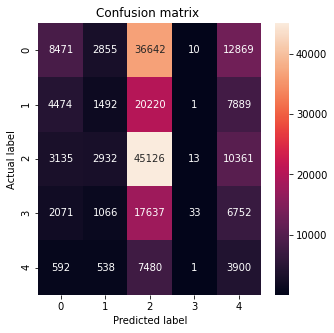

Text(0.5, 24.0, 'Predicted label')

In [0]:
# Se muestra matriz de confusión
cm1 = confusion_matrix(predict_test_pd["VAR_OBJETIVO"], predict_test_pd["prediction"])
plt.figure(figsize=(5,5))
sns.heatmap(cm1, annot=True, fmt="d")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')